## 2. Hash Functions
The objective of this test is to find how effective these hash functions are and measure load factor and collision ratio. The simplest hashing will be adding up their ASCII value to get cummulative sum and then modula with table size. But this method causes lot of collision due to simple additions. Plynomial hash function uses a polynomial coefficient which will be increasing power of a prime co-efficient. The prime number should also form an abellian group i.e, it should produce all the numbers in the range 0 to _prime number_.

### 2.1 Polynomial Hash
Let us start by representing a word using its ASCII value, so consider the word as $a_0, a_1,...,a_{n-1}$. and the hash polynomial as $p_0 \cdot X^0 + p_1 \cdot X^1 + ... + p_{n-1} \cdot X^{n-1}$. To compute polynomial hash index, we use the formula $$hash index = \sum\limits_{i=0}^{n-1} p_i \cdot X^i \cdot a_i$$ 
Hash polynomial should be irreducible. Irreducible polynomial cannot be factored into polynomials of lower degree, also with integer coefficients. irreducibility depends on the field or ring to which the coefficients are considered to belong. This source describes a few irreducible polynomials http://www.hpl.hp.com/techreports/98/HPL-98-135.pdf?jumpid=reg_R1002_USEN for the field size 2.

### 2.2 Non-cryptographic Hash Functions
#### 2.2.1 Murmur hash
Murmur is a family of general purpose hashing function (Non-cryptographic). The name comes from two basic operations Multiplication(MU) and Rotate(R). We use shift and XOR operations to perform the multiplications and rotate operations. Algorithm is taken from https://en.wikipedia.org/wiki/MurmurHash . Python and Julia has implementaions available. Murmur has good distribution, collision resistance, simple to implement and extremely fast in Intel architecture. it has good tradeoff between hardware usage and hash quality.
#### 2.2.2 xxHash
xxHash is general purpose hashing function. xxHash has high Memory bandwidth usage and works closely to the speed of RAM. Open source implementaion can be found here https://code.google.com/p/xxhash/.

Detailed comparision of hash functions http://programmers.stackexchange.com/questions/49550/which-hashing-algorithm-is-best-for-uniqueness-and-speed

### 2.3 Performance of Hash functions
Performance of hash function depends on distribution of hash values and minimal collision.
#### 2.3.1 Test machines
All the plots and analysis is done on workstation. We have also implemented a fast multithreaded version in C. Please check the source code.

- Workstation (Thinkpad L450)
    - CPU: Intel(R) Core(TM) i5-5200U CPU @ 2.20GHz
    - Memory: 4GB RAM @ 1600MHz with ECC enabled
    - OS: Ubuntu 14.04.1, kernel version 3.19.0-42-generic, x86_64 GNU/Linux
    
- Compute node (Triton - GPU001)
    - CPU: Intel(R) Xeon(R) CPU X5650  @ 2.67GHz
    - Memory: 24GB RAM @ ----MHz with ECC enabled
    - OS: Linux, kernel version  2.6.32-573.3.1.el6.x86_64, x86_64 GNU/Linux

#### 2.3.2 Distribution

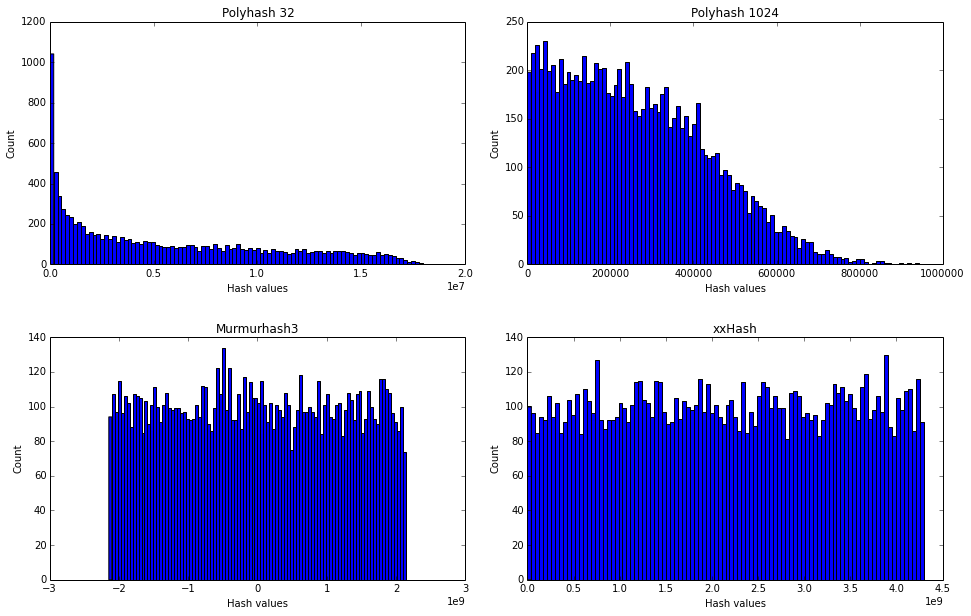

In [144]:
hashval_32 = []
hashval_1024 = []
hashval_murmur = []
hashval_xxhash = []
for i in range(0,10000):
    _len = random.randint(1,1024)
    _str = ''.join( [chr(random.randint(0,255)) for i in xrange(0,_len)])
    hashval_32.append(polyhash32(_str, 1234))
    hashval_1024.append(polyhash1024(_str, 1234))
    hashval_murmur.append(mmh3.hash(_str, 1234))
    hashval_xxhash.append(xxhash.xxh32(_str,seed=1234).intdigest())

rcParams['figure.figsize'] = 16, 10
fig = plt.figure()
gs = gridspec.GridSpec(2, 2,width_ratios=[1,1])
gs.update(wspace=0.15, hspace=0.3)
plot_collision(fig, gs, hashval_32, hashval_1024, hashval_murmur, hashval_xxhash)

Above plots describe hashing done on 10000 different input data with _same seed_. _Polynomial hash functions_ exhibit high collision compared to _Murmur_ and _xxHash_. Distribution of _Murmurhash_ and _xxHash_ is uniform.

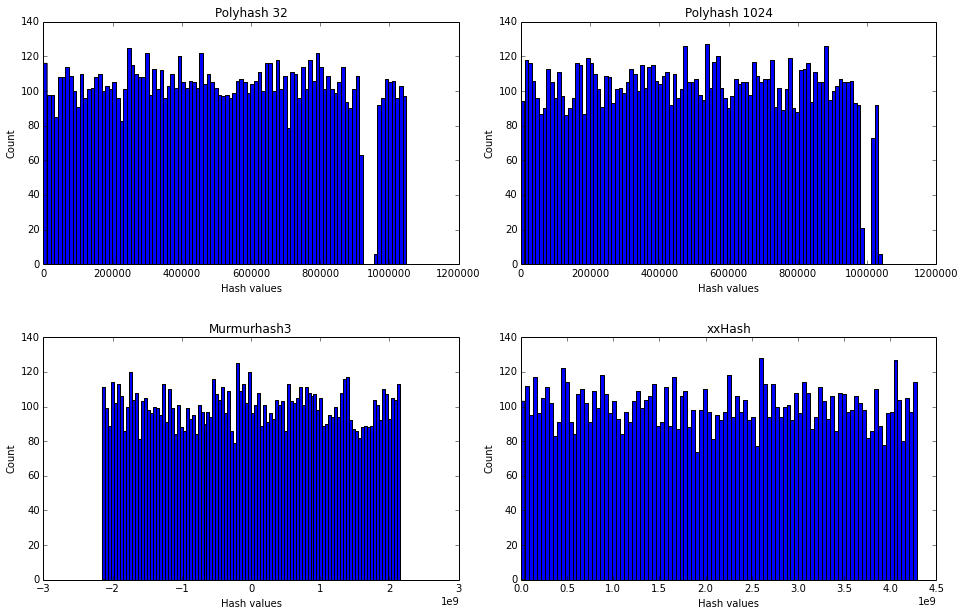

In [145]:
hashval_32 = []
hashval_1024 = []
hashval_murmur = []
hashval_xxhash = []
_str = ''.join( [chr(random.randint(0,255)) for i in xrange(0,random.randint(1,1024))])
for i in range(0,10000):
    _seed = random.randint(1,1000000)
    hashval_32.append(polyhash32(_str, _seed))
    hashval_1024.append(polyhash1024(_str, _seed))
    hashval_murmur.append(mmh3.hash(_str, _seed))
    hashval_xxhash.append(xxhash.xxh32(_str,seed=_seed).intdigest())

rcParams['figure.figsize'] = 16, 10
fig = plt.figure()
gs = gridspec.GridSpec(2, 2,width_ratios=[1,1])
gs.update(wspace=0.15, hspace=0.3)
plot_collision(fig, gs, hashval_32, hashval_1024, hashval_murmur, hashval_xxhash)


Hashing of same data (size 1024 characters) with 10000 different seeds. All the hash functions exibit relatively less collisions.

#### 2.3.3 Time Complexity

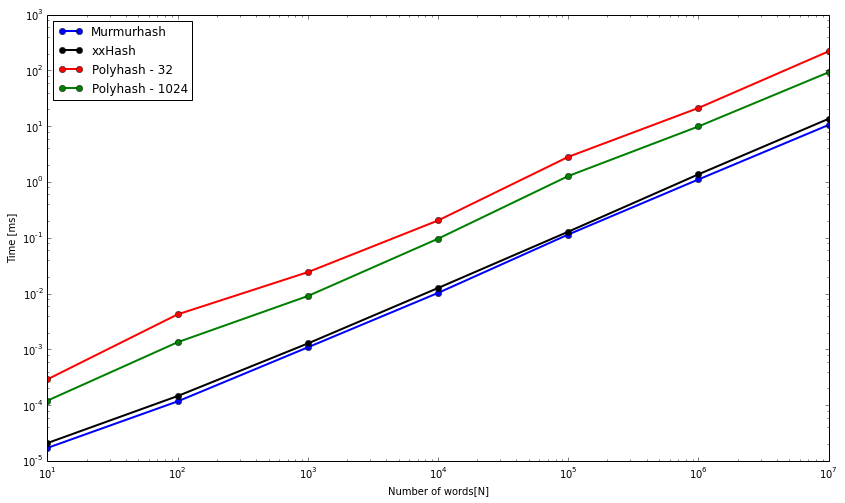

In [146]:
_file = "../data/twitter_words.txt"
_seed = 128
rcParams['figure.figsize'] = 14, 8
plot_runtime(_file, _seed, 8)

Performance of a hash function is the time taken to hash. Performance of Murmurhash and xxHash functions doesnot have much of difference, Murmurhash performs slightly better (no great performance change). Its surprising that the polyhash is taking more time than Murmurhash and xxHash which have signficantly less collision. With more careful implementation polyhash runtime can even be reduced. We are using the default library implementation of Murmur and xxHash function, whose implementations are carefully engineered.

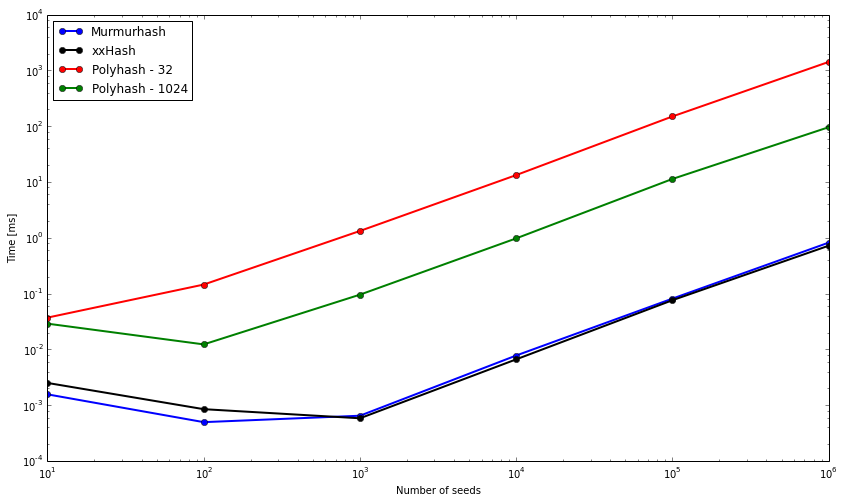

In [17]:
_str = ''.join( [chr(random.randint(0,255)) for i in xrange(0,1024)])
rcParams['figure.figsize'] = 14, 8
plot_runtime2(_str, 7)

Plots show the performance of hash functions with same data and different seeds. data of word is of size 1024 characters and seeds are randomly generated. In this case xxHash slightly outperforms Murmurhash with large input size (word length 1024).

## 3. Flajolet Martin Algorithm
Flajolet Martin algorithm is used to calculate the cardinality of the multiset or zeroth frequency moment. Time complexity is in the order of input data size $O(n)$ and space compexity is in the order of $O(h)$, where $h$ is the count of hash functions.

### 3.1 Algorithm
- Initialize a bit-vector $BITMAP$ to be of length $L$ and contain all 0's.
- For each element $x$ in $M$:
    - $index = \rho(\text{hash}(x))$.
    - $BITMAP[index] = 1$.
- Let $R$ denote the smallest index $i$ such that $BITMAP[i] = 0$.
- Estimate the cardinality of $M$ as $2^R / \phi$ where $\phi \approx 0.77351$.

In [19]:
_file = "../data/twitter_words.txt"
print "Exact computation (F0, F2):", F0F2_exact(_file, 1000)
print "F0 Approximation Polyhash32: ",fma(_file, 1000, 100, 0.1, "polyhash32")
print "F0 Approximation Polyhash1024: ", fma(_file, 1000, 100, 0.1, "polyhash1024")
print "F0 Approximation Murmurhash: ", fma(_file, 1000, 100, 0.1, "murmurhash")
print "F0 Approximation xxHash: ", fma(_file, 1000, 100, 0.1, "xxhash")

Exact computation (F0, F2): (843, 2377)
F0 Approximation Polyhash32:  595
F0 Approximation Polyhash1024:  595
F0 Approximation Murmurhash:  959
F0 Approximation xxHash:  711


### 3.2 Performance

#### 3.2.1 Quality of Hash functions
Performance of hash function depends on the randomness and collision ratio of the hash functions. It is generally observed that more costly hash functions to exhibit less collision ratio and better randomness. Hence the performance of costly hash functions will be usually better. But in our case polyhash is costly and giving hash with high collision ratio. So our expectation was that the approximation of _xxHash_ and _Murmurhash_ has to be better than _polynomial hash functions_, which is also the case here. Approximation of _Murmur_ and _xxHash_ is better.

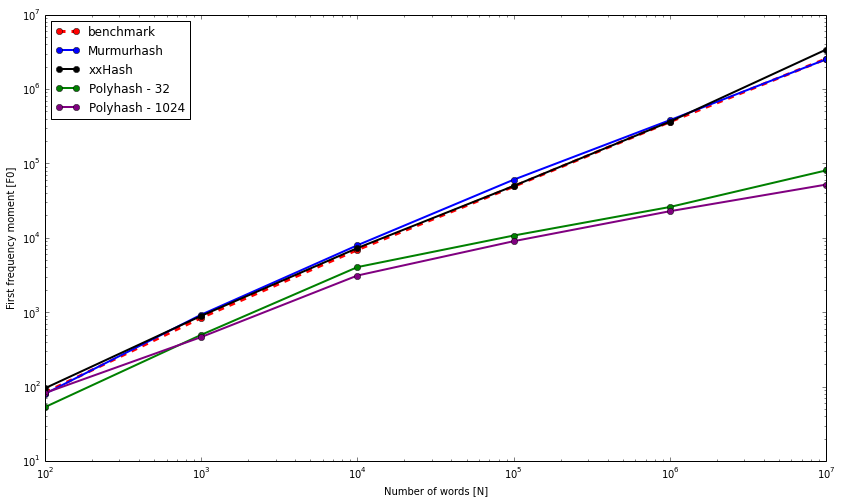

In [22]:
rcParams['figure.figsize'] = 14, 8
fma_compare_hashfuncs(8)

Above plots show the approximation of $F_0$ using different hash functions. Our test results are based on 100 different hash functions for each family and grouping factor of 0.1 to choose the median (mean of medians is used to get better approximation results).

#### 3.2.2 Count of Hash functions
From the plots we infer that quality (collision ratio) of hash functions helps in getting better approximation results. Increasing the hash functions count improves approximation results intially for small value of hash function count but having too many hash functions doesnot improve the approximation results.

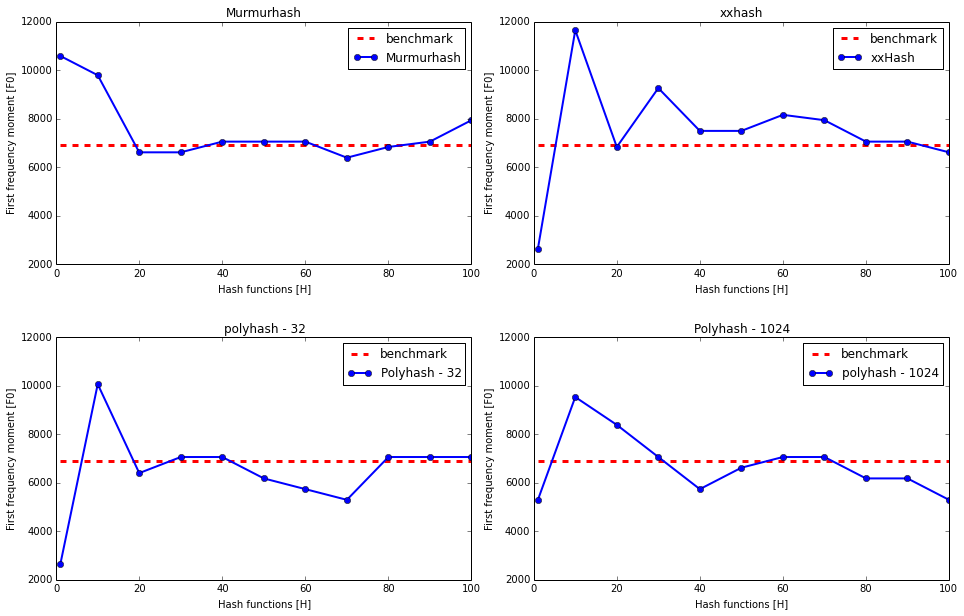

In [29]:
fma_compare_hashcount(10000, [1,10,20,30,40,50,60,70,80,90,100], 0.15)

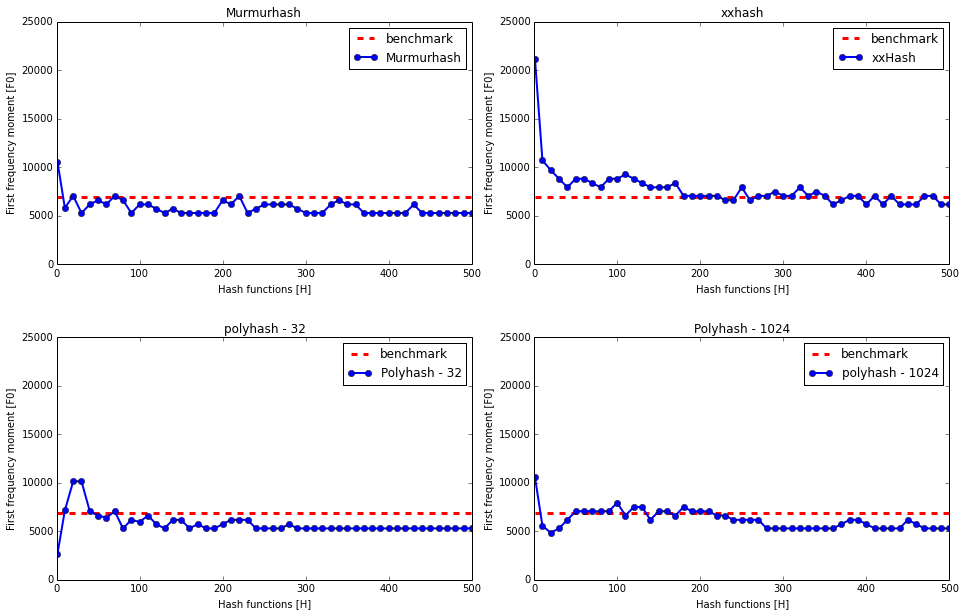

In [30]:
fma_compare_hashcount(10000, 
                      [1,10,20,30,40,50,60,70,80,90,100,
                       110,120,130,140,150,160,170,180,190,200,
                       210,220,230,240,250,260,270,280,290,300,
                       310,320,330,340,350,360,370,380,390,400,
                       410,420,430,440,450,460,470,480,490,500], 0.15)

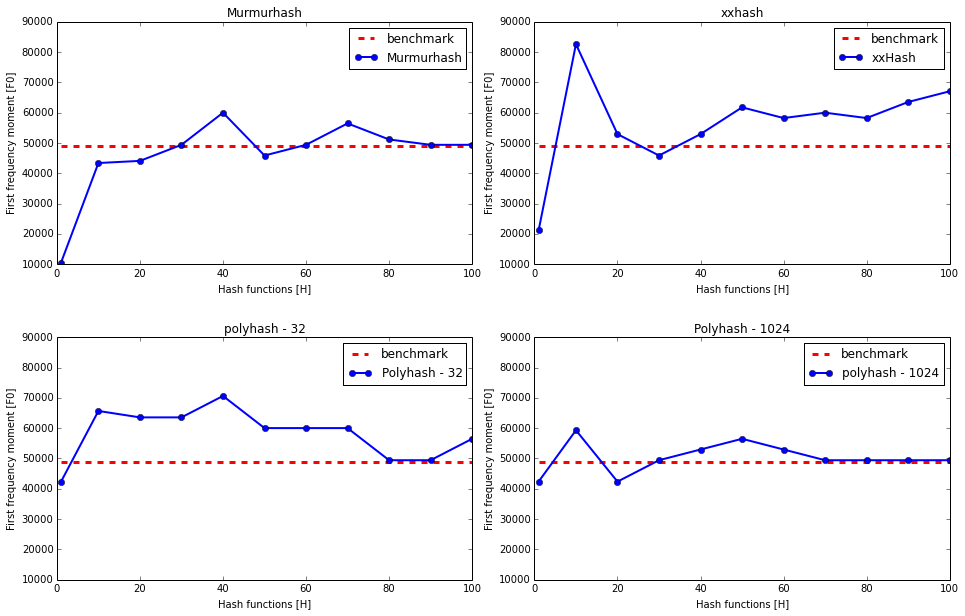

In [31]:
fma_compare_hashcount(100000, [1,10,20,30,40,50,60,70,80,90,100], 0.15)

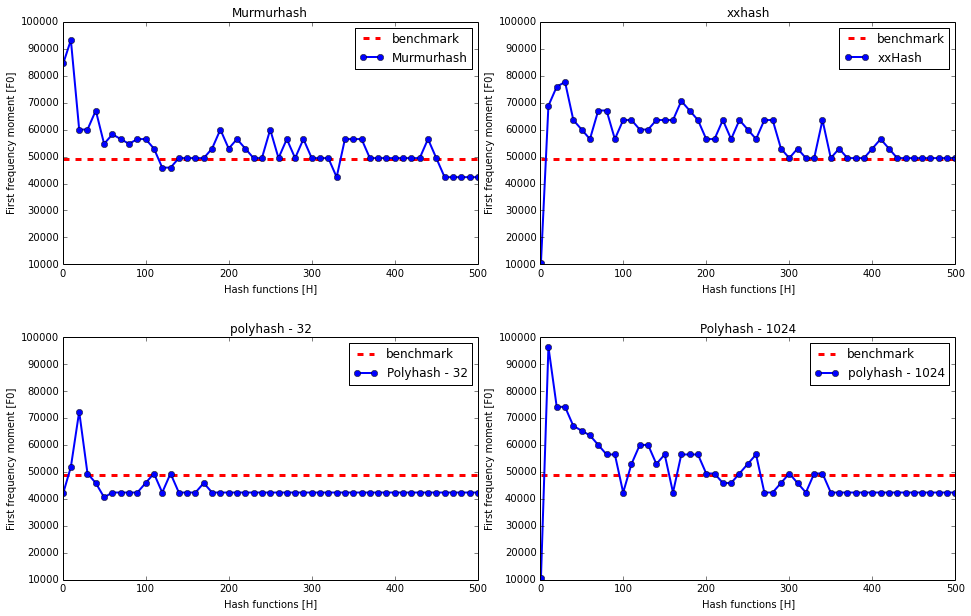

In [32]:
fma_compare_hashcount(100000, 
                      [1,10,20,30,40,50,60,70,80,90,100,
                       110,120,130,140,150,160,170,180,190,200,
                       210,220,230,240,250,260,270,280,290,300,
                       310,320,330,340,350,360,370,380,390,400,
                       410,420,430,440,450,460,470,480,490,500], 0.15)

## Alon Matias Szegedy

In [ ]:
def ams(_file, N, M):
    _dict = collections.OrderedDict()
    lines = list(islice(open(_file), N))
    val = 0
    while len(_dict) < M:
        line = random.choice(lines)
        if not re.match(r'^\s*$', line):
            if line not in _dict:
                _dict[line] = 0
    for line in lines:
        if not re.match(r'^\s*$', line):
            if line in _dict:
                _dict[line] += 1
    #return sum(map(lambda x: N*(2*x-1), _dict.values()))/M
    return np.array(_dict.values())

In [ ]:
ams("../data/twitter_words.txt", 100000, 30000)

In [ ]:
F0F2_exact("../data/twitter_words.txt", 100000)

In [ ]:
exact = collections.defaultdict(int);
F2_dict = collections.defaultdict(list)

for N in [ pow(10,j) for j in range(3,6)]:
    f0, f2 = F0F2_exact("../data/twitter_words.txt", N)
    C = ams("../data/twitter_words.txt", N, f0)
    exact[N] = f2
    for M in [ int(f0 * j) for j in np.arange(0.05, 1.05, 0.05)]: 
        F2_dict[N].append(sum(map(lambda x : N*(2*x-1), C[0:M]))/M)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
for key, value in F2_dict.iteritems():
    ret = ax.scatter([int(x=key) for i in range(0,len(value))], value, alpha=0.5)
X=[]
Y=[]
for key, value in sorted(exact.items()):
    X.append(key)
    Y.append(value)
ret = ax.plot(X, Y, marker='o', mew=1, linewidth=2, color='green')

X=[]
Y=[]
for key, value in sorted(F2_dict.items()):
    X.append(key)
    Y.append(sum(value)/len(value))
ret = ax.plot(X, Y, marker='o', color='red', linewidth=2)

In [ ]:
def shittyhash(_str):
    ret = polyhash32(_str,1234)
    if ret%2:
        return -1
    else:
        return 1

In [ ]:
def ams2(_file, N, M):
    lines = list(islice(open(_file), N))
    for line in lines:
        if not re.match(r'^\s*$', line):
            val = shittyhash(line)
            

In [ ]:
ams2("../data/twitter_words.txt", 10, 10)

## Appendix

### Includes

In [2]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec

from itertools import islice
import collections
import re

import mmh3
import xxhash
import time
import gmpy 
import math

### Implementation of Polynomial Hash functions

In [4]:
#X^32 = X^0 + X^2 + X^3 + X^7
poly_32 = np.zeros(32)
poly_32[0] = 1
poly_32[2] = 1
poly_32[3] = 1 
poly_32[7] = 1

#X^1024 = X^8 + X^7 + X^4 + X^0
poly_1024 = np.zeros(1024)
poly_1024[0] = 1
poly_1024[4] = 1
poly_1024[7] = 1
poly_1024[8] = 1

def polyhash32(_str, seed):
    _sum = 0
    hashInd = 0
    for index, item in enumerate(_str):
        _sum += ord(item)
        hashInd += (ord(item)  * poly_32[index%32])
    return int((int((np.mod(hashInd, _sum) * len(_str)))^seed) % (1<<32))

def polyhash1024(_str, seed):
    _sum = 0
    hashInd = 0
    _len = len(_str)
    for index, item in enumerate(_str):
        _sum += (ord(item))
    if(_len >= 9):
        hashInd = ((ord(_str[8]) * poly_1024[8]) + (ord(_str[7]) * poly_1024[7]) + 
                   (ord(_str[4] * poly_1024[4])) + (ord(_str[0] * poly_1024[0])))
    if(_len < 9 and _len >= 8):
        hashInd = ((ord(_str[7]) * poly_1024[7]) + (ord(_str[4] * poly_1024[4])) +
                   (ord(_str[0] * poly_1024[0])))
    if(_len < 8 and _len >=5):
        hashInd = ((ord(_str[4] * poly_1024[4])) + (ord(_str[0] * poly_1024[0]))) 
    if(_len < 5):
        hashInd = (ord(_str[0] * poly_1024[0]))
    return int((int((np.mod(hashInd, _sum) * len(_str)))^seed) % (1<<32))

In [6]:
polyhash1024("abcd", 123)

511

### Collision

In [7]:
def plot_collision(ax, gs, hashval_32, hashval_1024, hashval_murmur, hashval_xxhash):
    ax = fig.add_subplot(gs[0])
    ax.set_title("Polyhash 32")
    ax.set_xlabel("Hash values")
    ax.set_ylabel("Count")
    (n, bins, patches) = ax.hist(hashval_32, bins=100)

    ax = fig.add_subplot(gs[1])
    ax.set_title("Polyhash 1024")
    ax.set_xlabel("Hash values")
    ax.set_ylabel("Count")
    (n, bins, patches) = ax.hist(hashval_1024, bins=100)

    ax = fig.add_subplot(gs[2])
    ax.set_title("Murmurhash3")
    ax.set_xlabel("Hash values")
    ax.set_ylabel("Count")
    (n, bins, patches) = ax.hist(hashval_murmur, bins=100)

    ax = fig.add_subplot(gs[3])
    ax.set_title("xxHash")
    ax.set_xlabel("Hash values")
    ax.set_ylabel("Count")
    (n, bins, patches) = ax.hist(hashval_xxhash, bins=100)

### Test code for hash functions

In [8]:
def test_polyhash32(lines, _seed):
    start = time.time()
    for line in lines:
        if not re.match(r'^\s*$', line):
            polyhash32(line, _seed)
    return (time.time() - start)
            
def test_polyhash1024(lines, _seed):
    start = time.time()
    for line in lines:
        if not re.match(r'^\s*$', line):
            polyhash1024(line, _seed)
    return (time.time() - start)
            
def test_murmur(lines, _seed):
    start = time.time()
    for line in lines:
        if not re.match(r'^\s*$', line):
            mmh3.hash(line, _seed)
    return (time.time() - start)
            
def test_xxHash(lines, _seed):
    start = time.time()
    for line in lines:
        if not re.match(r'^\s*$', line):
            xxhash.xxh32(line, seed=_seed).intdigest()
    return (time.time() - start)

In [9]:
def plot_runtime(_file, _seed, _pow):
    X = []
    time_32 = []
    time_1024 = []
    time_murmur = []
    time_xxhash = []
    for N in [ pow(10,j) for j in range(1,_pow)]:
        lines = list(islice(open(_file), N))
        X.append(N)
        time_32.append(test_polyhash32(lines,_seed))
        time_1024.append(test_polyhash1024(lines,_seed))
        time_murmur.append(test_murmur(lines,_seed))
        time_xxhash.append(test_xxHash(lines,_seed))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Number of words[N]")
    ax.set_ylabel("Time [ms]")
    ret = ax.plot(X, time_murmur, marker='o', color='blue', linewidth=2, label="Murmurhash")
    ret = ax.plot(X, time_xxhash, marker='o', color='black', linewidth=2, label="xxHash")
    ret = ax.plot(X, time_32, marker='o', color='red', linewidth=2, label="Polyhash - 32")
    ret = ax.plot(X, time_1024, marker='o', color='green', linewidth=2, label="Polyhash - 1024")
    leg = ax.legend(loc='best')

In [10]:
def test_polyhash32_1(_str, seeds):
    start = time.time()
    for _seed in seeds:
        polyhash32(_str,_seed)
    return (time.time() - start)

def test_polyhash1024_1(_str, seeds):
    start = time.time()
    for _seed in seeds:
        polyhash1024(_str, _seed)
    return (time.time() - start)

def test_murmur_1(_str, seeds):
    start = time.time()
    for _seed in seeds:
        mmh3.hash(_str, _seed)
    return (time.time() - start)

def test_xxHash_1(_str, seeds):
    start = time.time()
    for _seed in seeds:
        xxhash.xxh32(_str, seed=_seed).intdigest()
    return (time.time() - start)
        

In [17]:
def plot_runtime2(_str, _pow):
    X = []
    time_32 = []
    time_1024 = []
    time_murmur = []
    time_xxhash = []
    for N in [ pow(10,j) for j in range(1,_pow)]:
        seeds = random.sample(range(1, 100000000), N)
        X.append(N)
        time_32.append(test_polyhash32_1(_str, seeds))
        time_1024.append(test_polyhash1024_1(_str, seeds))
        time_murmur.append(test_murmur_1(_str, seeds))
        time_xxhash.append(test_xxHash_1(_str, seeds))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Number of seeds")
    ax.set_ylabel("Time [ms]")
    ret = ax.plot(X, time_murmur, marker='o', color='blue', linewidth=2, label="Murmurhash")
    ret = ax.plot(X, time_xxhash, marker='o', color='black', linewidth=2, label="xxHash")
    ret = ax.plot(X, time_32, marker='o', color='red', linewidth=2, label="Polyhash - 32")
    ret = ax.plot(X, time_1024, marker='o', color='green', linewidth=2, label="Polyhash - 1024")
    leg = ax.legend(loc='best')

### Frequency moments
Exact computation one pass

In [5]:
def F0F2_exact(_file, N):
    _dict = dict()
    lines = list(islice(open(_file), N))
    for line in lines:
        if not re.match(r'^\s*$', line):
            if line not in _dict:
                _dict[line] = 1
            else:
                _dict[line] += 1
    return len(_dict), sum(map(lambda x: x * x, _dict.values()))

In [4]:
def _fma(_file, N, M, gsize, hash_func):
    lines = list(islice(open(_file), N))
    seeds = random.sample(range(1,10000000), M)
    bitmap = np.zeros((M,), dtype=np.int)
    for _line in lines:
        if not re.match(r'^\s*$', _line):
            for index, _seed in enumerate(seeds):
                if hash_func == "polyhash32":
                    _hash = polyhash32(_line, _seed)
                elif hash_func == "polyhash1024":
                    _hash = polyhash1024(_line, _seed)
                elif hash_func == "xxhash":
                    _hash = xxhash.xxh32(_line, seed=_seed).intdigest()
                else:
                    _hash = mmh3.hash(_line, _seed)
                
                if(_hash): #if not zero
                    lsb = (gmpy.scan1(_hash)) #returns LSB index
                bitmap[index] = (bitmap[index] | (1 << lsb))
                #if  lsb > max_bit[index]:
                    #max_bit[index] = lsb
    min_bit = [ gmpy.scan0(x) for x in bitmap ]
    approx_res = [ pow(2, _bit) for _bit in min_bit]
    arrays = np.array_split(approx_res, math.floor(M / math.ceil(M*gsize)))
    _median = []
    for _arr in arrays:
        _median.append(np.median(_arr))
    return min_bit, _median, int((sum(_median)/len(_median)) / 0.773351)
    #return int((sum(_median)/len(_median)) / 0.773351)

In [6]:
def fma(_file, N, M, gsize, hash_func):
    min_bin, _median, _f0 = _fma(_file, N, M, gsize, hash_func)
    return _f0

## Compare Hash functions
Comparing performance of hash functions for approximating zeroth frequency moment.

In [7]:
def fma_compare_hashfuncs(_pow):
    _file = "../data/twitter_words.txt"
    X = []
    f0_poly32 = []
    f0_poly1024 = []
    f0_murmur = []
    f0_xxhash = []
    f0_exact = []
    for N in [pow(10,i) for i in range(2,_pow)]:
        f0, f2 = F0F2_exact(_file, N)
        X.append(N)
        f0_exact.append(f0)
        f0_poly32.append( fma(_file, N, 100, 0.1, "polyhash32"))
        f0_poly1024.append( fma(_file, N, 100, 0.1, "polyhash1024"))
        f0_murmur.append( fma(_file, N, 100, 0.1, "murmurhash"))
        f0_xxhash.append( fma(_file, N, 100, 0.1, "xxhash"))
    # Plots
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Number of words [N]")
    ax.set_ylabel("First frequency moment [F0]")
    ret = ax.plot(X, f0_exact, marker='o', color='red', linewidth=3, label="benchmark", linestyle='--')
    ret = ax.plot(X, f0_murmur, marker='o', color='blue', linewidth=2, label="Murmurhash")
    ret = ax.plot(X, f0_xxhash, marker='o', color='black', linewidth=2, label="xxHash")
    ret = ax.plot(X, f0_poly32, marker='o', color='green', linewidth=2, label="Polyhash - 32")
    ret = ax.plot(X, f0_poly1024, marker='o', color='#800080', linewidth=2, label="Polyhash - 1024")
    leg = ax.legend(loc='best')

In [23]:
def mean_of_median(array, M, gsize):
    array_sub = list(array[:M])
    arrays = np.array_split(array_sub, math.floor(M / math.ceil(M*gsize)))
    _median = []
    for _arr in arrays:
        _median.append(np.median(_arr))    
    return int((sum(_median)/len(_median)) / 0.773351)
    
def fma_compare_hashcount(N, funcs_list, gsize):
    _file = "../data/twitter_words.txt"
    X = []
    f0_exact = []
    f0_murmur = []
    f0_xxhash = []
    f0_poly32 = []
    f0_poly1024 = []
    f0, f2 = F0F2_exact(_file, N)
    count = max(funcs_list)

    murmur_minbit, murmur_median, murmur_f0 = _fma(_file, N, count, 0.2, "murmurhash")
    xxhash_minbit, xxhash_median, xxhash_f0 = _fma(_file, N, count, 0.2, "xxhash")
    poly32_minbit, poly32_median, poly32_f0 = _fma(_file, N, count, 0.2, "poly32")
    poly1024_minbit, poly1024_median, poly1024_f0 = _fma(_file, N, count, 0.2, "poly1024")
    #print murmur_minbit, murmur_median, murmur_f0
    
    murmur_res = [ pow(2, _bit) for _bit in murmur_minbit]
    xxhash_res = [ pow(2, _bit) for _bit in xxhash_minbit]
    poly32_res = [ pow(2, _bit) for _bit in poly32_minbit]
    poly1024_res = [ pow(2, _bit) for _bit in poly1024_minbit]
    
    for M in funcs_list:
        X.append(M)
        f0_exact.append(f0)
        f0_murmur.append(mean_of_median(murmur_res, M, gsize))
        f0_xxhash.append(mean_of_median(xxhash_res, M, gsize))
        f0_poly32.append(mean_of_median(poly32_res, M, gsize))
        f0_poly1024.append(mean_of_median(poly1024_res, M, gsize))
    
    #print f0
    #print f0_murmur
    #print f0_xxhash
    #print f0_poly32
    #print f0_poly1024
    
    # Plots   
    rcParams['figure.figsize'] = 16, 10
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 2,width_ratios=[1,1])
    ret = gs.update(wspace=0.15, hspace=0.3)
    
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])
    ax1.get_shared_y_axes().join(ax1, ax2, ax3, ax4)
    
    ax1.set_xlabel("Hash functions [H]")
    ax1.set_ylabel("First frequency moment [F0]")
    ax1.set_title("Murmurhash")
    ret = ax1.plot(X, f0_exact, color='red', linewidth=3, label="benchmark", linestyle='--')
    ret = ax1.plot(X, f0_murmur, marker='o', color='blue', linewidth=2, label="Murmurhash")
    leg = ax1.legend(loc='best')
    
    #ax = fig.add_subplot(gs[1])
    ax2.set_xlabel("Hash functions [H]")
    ax2.set_ylabel("First frequency moment [F0]")
    ax2.set_title("xxhash")
    ret = ax2.plot(X, f0_exact, color='red', linewidth=3, label="benchmark", linestyle='--')
    ret = ax2.plot(X, f0_xxhash, marker='o', color='blue', linewidth=2, label="xxHash")
    leg = ax2.legend(loc='best')
    
    #ax = fig.add_subplot(gs[2])
    ax3.set_xlabel("Hash functions [H]")
    ax3.set_ylabel("First frequency moment [F0]")
    ax3.set_title("polyhash - 32")
    ret = ax3.plot(X, f0_exact, color='red', linewidth=3, label="benchmark", linestyle='--')
    ret = ax3.plot(X, f0_poly32, marker='o', color='blue', linewidth=2, label="Polyhash - 32")
    leg = ax3.legend(loc='best')
    
    #ax = fig.add_subplot(gs[3])
    ax4.set_xlabel("Hash functions [H]")
    ax4.set_ylabel("First frequency moment [F0]")
    ax4.set_title("Polyhash - 1024")
    ret = ax4.plot(X, f0_exact, color='red', linewidth=3, label="benchmark", linestyle='--')
    ret = ax4.plot(X, f0_poly1024, marker='o', color='blue', linewidth=2, label="polyhash - 1024")
    leg = ax4.legend(loc='best')
    

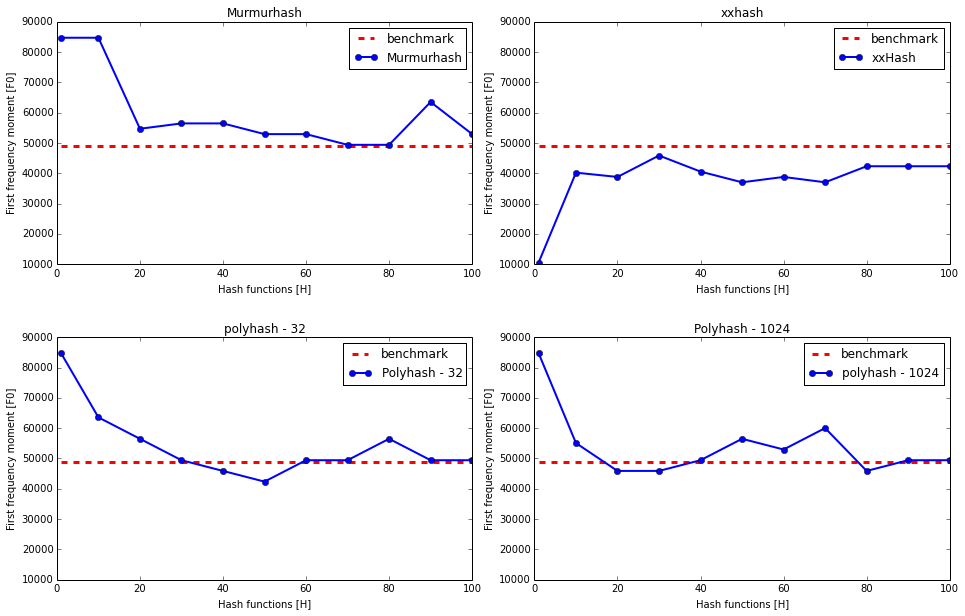

In [27]:
fma_compare_hashcount(100000, [1,10,20,30,40,50,60,70,80,90,100], 0.15)